In [1]:
#pseudo label -> randomrain
#crash auto label and confidence기반 수작업 -> night
# pip uninstall opencv-python-headless==4.5.5.62
#pip install opencv-python-headless==4.5.2.52
#torch.cuda.empty_cache()

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import KFold,StratifiedKFold
import albumentations as A

from datetime import datetime
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch.losses import FocalLoss
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import random
import os
import cv2
from tqdm import tqdm
from transformers import AutoModel, AutoImageProcessor, AutoConfig

import warnings

warnings.filterwarnings("ignore")


In [3]:
### https://github.com/davda54/sam

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
import pandas as pd
all_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [6]:
all_df

,sample_id,video_path,label
0,TRAIN_0000,./train/TRAIN_0000.mp4,7
1,TRAIN_0001,./train/TRAIN_0001.mp4,7
2,TRAIN_0002,./train/TRAIN_0002.mp4,0
3,TRAIN_0003,./train/TRAIN_0003.mp4,0
4,TRAIN_0004,./train/TRAIN_0004.mp4,1
...,...,...,...
2693,TRAIN_2693,./train/TRAIN_2693.mp4,3
2694,TRAIN_2694,./train/TRAIN_2694.mp4,5
2695,TRAIN_2695,./train/TRAIN_2695.mp4,0
2696,TRAIN_2696,./train/TRAIN_2696.mp4,0


In [7]:
all_df['label'].value_counts()

0     1783
1      318
7      317
3       78
2       51
9       34
11      33
8       30
5       28
4       13
12       6
10       4
6        3
Name: label, dtype: int64

In [8]:

CFG = {
    'VIDEO_LENGTH':50, 
    'IMG_SIZE':180,
    'EPOCHS':4,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':2,
    'SEED':2023,
    'SPLIT':5,
    'ROOT':'./data',
    'MODEL':'MCG-NJU/videomae-base-finetuned-ssv2',
    'LOAD_WEIGHT':False,
    'LOAD_WEIGHT_NAME' :'a',
    'VAL_SCORE_THRES' : 0.98,
    'NUM_ASB':4,
    'DATA_GENERATE_THRES':6.5,
}

In [9]:
skf = StratifiedKFold(n_splits = CFG['SPLIT'])

In [10]:
all_df['video_path'] = all_df['video_path'].apply(lambda x:CFG['ROOT']+x[1:])
test_df['video_path'] = test_df['video_path'].apply(lambda x:CFG['ROOT']+x[1:])

crash_df = all_df.copy()
crash_df['label'] = crash_df['label'].apply(lambda x: 1 if x != 0 else 0)


In [11]:
ego_df = all_df.copy()
idx = ego_df[ego_df['label']==0].index
ego_df.drop(idx,inplace=True)
#0:no 1:yes
ego_df['label'] = ego_df['label'].apply(lambda x: 1 if x < 7 else 0)
ego_df.reset_index(drop=True,inplace=True)

In [12]:
weather_df = all_df.copy()
idx = weather_df[weather_df['label']==0].index
weather_df.drop(idx,inplace=True)
#0:normal,1:snow,2:rain
weather_df['label'] = weather_df['label'].apply(lambda x: 0 if x==1 or x==2 or x==7 or x==8 else 1 if x==3 or x==4 or x==8 or x==9 else 2)
weather_df.reset_index(drop=True,inplace=True)

In [13]:
time_df = all_df.copy()
idx = time_df[time_df['label']==0].index
time_df.drop(idx,inplace=True)
#0:day 1:night
time_df['label'] = time_df['label'].apply(lambda x: 0 if x%2==1 else 1)
time_df.reset_index(drop=True,inplace=True)

In [14]:
noncrash_ego_df = pd.read_csv('./g_data/ego_g_df.csv')
ego_df = pd.concat([ego_df, noncrash_ego_df])
ego_df.reset_index(drop=True,inplace=True)
# noncrash_ego_df

In [15]:
noncrash_weather_df = pd.read_csv('./g_data/weather_g_df.csv')
weather_df = pd.concat([weather_df, noncrash_weather_df])
weather_df.reset_index(drop=True,inplace=True)


In [16]:
noncrash_time_df = pd.read_csv('./g_data/time_g_df.csv')
time_df = pd.concat([time_df, noncrash_time_df])
time_df.reset_index(drop=True,inplace=True)


In [17]:
all_df

,sample_id,video_path,label
0,TRAIN_0000,./data/train/TRAIN_0000.mp4,7
1,TRAIN_0001,./data/train/TRAIN_0001.mp4,7
2,TRAIN_0002,./data/train/TRAIN_0002.mp4,0
3,TRAIN_0003,./data/train/TRAIN_0003.mp4,0
4,TRAIN_0004,./data/train/TRAIN_0004.mp4,1
...,...,...,...
2693,TRAIN_2693,./data/train/TRAIN_2693.mp4,3
2694,TRAIN_2694,./data/train/TRAIN_2694.mp4,5
2695,TRAIN_2695,./data/train/TRAIN_2695.mp4,0
2696,TRAIN_2696,./data/train/TRAIN_2696.mp4,0


In [18]:
ego_df

,sample_id,video_path,label
0,TRAIN_0000,./data/train/TRAIN_0000.mp4,0
1,TRAIN_0001,./data/train/TRAIN_0001.mp4,0
2,TRAIN_0004,./data/train/TRAIN_0004.mp4,1
3,TRAIN_0006,./data/train/TRAIN_0006.mp4,1
4,TRAIN_0007,./data/train/TRAIN_0007.mp4,0
...,...,...,...
946,NaN,./data/train/TRAIN_2267.mp4,1
947,NaN,./data/train/TRAIN_2463.mp4,1
948,NaN,./data/train/TRAIN_2475.mp4,1
949,NaN,./data/train/TRAIN_2488.mp4,1


In [19]:
crash_df

,sample_id,video_path,label
0,TRAIN_0000,./data/train/TRAIN_0000.mp4,1
1,TRAIN_0001,./data/train/TRAIN_0001.mp4,1
2,TRAIN_0002,./data/train/TRAIN_0002.mp4,0
3,TRAIN_0003,./data/train/TRAIN_0003.mp4,0
4,TRAIN_0004,./data/train/TRAIN_0004.mp4,1
...,...,...,...
2693,TRAIN_2693,./data/train/TRAIN_2693.mp4,1
2694,TRAIN_2694,./data/train/TRAIN_2694.mp4,1
2695,TRAIN_2695,./data/train/TRAIN_2695.mp4,0
2696,TRAIN_2696,./data/train/TRAIN_2696.mp4,0


In [20]:
weather_df

,sample_id,video_path,label
0,TRAIN_0000,./data/train/TRAIN_0000.mp4,0
1,TRAIN_0001,./data/train/TRAIN_0001.mp4,0
2,TRAIN_0004,./data/train/TRAIN_0004.mp4,0
3,TRAIN_0006,./data/train/TRAIN_0006.mp4,1
4,TRAIN_0007,./data/train/TRAIN_0007.mp4,0
...,...,...,...
921,NaN,./data/train/TRAIN_1536.mp4,1
922,NaN,./data/train/TRAIN_1557.mp4,1
923,NaN,./data/train/TRAIN_1653.mp4,1
924,NaN,./data/train/TRAIN_1951.mp4,1


In [21]:
time_df

,sample_id,video_path,label
0,TRAIN_0000,./data/train/TRAIN_0000.mp4,0
1,TRAIN_0001,./data/train/TRAIN_0001.mp4,0
2,TRAIN_0004,./data/train/TRAIN_0004.mp4,0
3,TRAIN_0006,./data/train/TRAIN_0006.mp4,0
4,TRAIN_0007,./data/train/TRAIN_0007.mp4,0
...,...,...,...
2316,NaN,./data/train/TRAIN_2681.mp4,0
2317,NaN,./data/train/TRAIN_2684.mp4,0
2318,NaN,./data/train/TRAIN_2686.mp4,0
2319,NaN,./data/train/TRAIN_2688.mp4,0


In [22]:
noncrash_df = all_df[all_df['label']==0]
noncrash_df.reset_index(drop=True,inplace=True)
noncrash_df

,sample_id,video_path,label
0,TRAIN_0002,./data/train/TRAIN_0002.mp4,0
1,TRAIN_0003,./data/train/TRAIN_0003.mp4,0
2,TRAIN_0005,./data/train/TRAIN_0005.mp4,0
3,TRAIN_0008,./data/train/TRAIN_0008.mp4,0
4,TRAIN_0010,./data/train/TRAIN_0010.mp4,0
...,...,...,...
1778,TRAIN_2690,./data/train/TRAIN_2690.mp4,0
1779,TRAIN_2691,./data/train/TRAIN_2691.mp4,0
1780,TRAIN_2695,./data/train/TRAIN_2695.mp4,0
1781,TRAIN_2696,./data/train/TRAIN_2696.mp4,0


In [23]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [24]:
from transformers import VideoMAEConfig, VideoMAEModel
from transformers import AutoImageProcessor, VideoMAEForVideoClassification
from transformers import XCLIPVisionModel, XCLIPVisionConfig


crash_configuration = VideoMAEConfig()
crash_configuration = AutoConfig.from_pretrained(CFG['MODEL'])
crash_configuration.num_frames = CFG['VIDEO_LENGTH']
crash_configuration.num_frames=CFG['VIDEO_LENGTH']
crash_configuration.image_size=CFG['IMG_SIZE']
crash_configuration.id2label = {0:'no crash',1:'crash'}
crash_configuration.label2id = {'no crash':0,'crash':1}
crash_model = VideoMAEForVideoClassification.from_pretrained(CFG['MODEL'],config=crash_configuration,ignore_mismatched_sizes=True)

ego_configuration = VideoMAEConfig()
ego_configuration = AutoConfig.from_pretrained(CFG['MODEL'])
ego_configuration.num_frames = CFG['VIDEO_LENGTH']
ego_configuration.num_frames=CFG['VIDEO_LENGTH']
ego_configuration.image_size=CFG['IMG_SIZE']
ego_configuration.id2label = {0:'other',1:'ego'}
ego_configuration.label2id = {'other':0,'ego':1}
ego_model = VideoMAEForVideoClassification.from_pretrained(CFG['MODEL'],config=ego_configuration,ignore_mismatched_sizes=True)

weather_configuration = VideoMAEConfig()
weather_configuration = AutoConfig.from_pretrained(CFG['MODEL'])
weather_configuration.num_frames = CFG['VIDEO_LENGTH']
weather_configuration.num_frames=CFG['VIDEO_LENGTH']
weather_configuration.image_size=CFG['IMG_SIZE']
weather_configuration.id2label = {0:'normal',1:'snow',2:'rain'}
weather_configuration.label2id = {'normal':0,'snow':1,'rain':2}
weather_model = VideoMAEForVideoClassification.from_pretrained(CFG['MODEL'],config=weather_configuration,ignore_mismatched_sizes=True)

time_configuration = VideoMAEConfig()
time_configuration = AutoConfig.from_pretrained(CFG['MODEL'])
time_configuration.num_frames = CFG['VIDEO_LENGTH']
time_configuration.num_frames=CFG['VIDEO_LENGTH']
time_configuration.image_size=CFG['IMG_SIZE']
time_configuration.id2label = {0:'day',1:'night'}
time_configuration.label2id = {'day':0,'night':1}
time_model = VideoMAEForVideoClassification.from_pretrained(CFG['MODEL'],config=time_configuration,ignore_mismatched_sizes=True)


image_processor_config = AutoImageProcessor.from_pretrained(CFG['MODEL'])



Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-ssv2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([174, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([174]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-ssv2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([174, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([174]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN

In [25]:
import matplotlib.pyplot as plt

def visualize(image):
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(image)

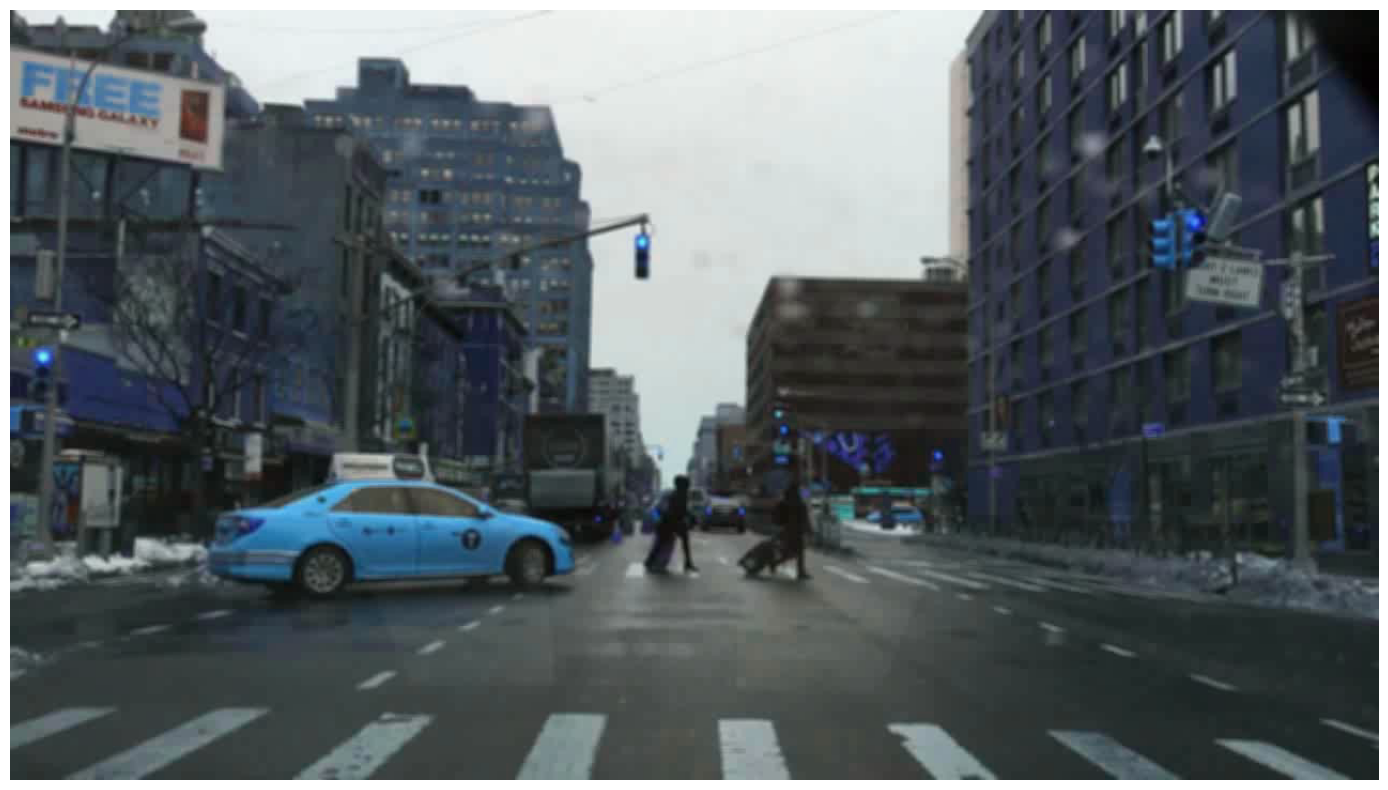

In [26]:

# path = all_df['video_path'][649]
path = './data/train/TRAIN_2277.mp4'
frames=[]
cap = cv2.VideoCapture(path)
for idx in range(50):
    if idx%5 == 3:
        _, img = cap.read()
        frames.append(img)
visualize(frames[0])

In [27]:
# rain_alb = A.Compose([
#         A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=6, p=1),
#     ], p=1)


# def pseudo_label(path,tfms):
#     pseudo_frame = []
#     frames=[]
#     cap = cv2.VideoCapture(path)
#     for idx in range(50):
#         if idx%5 == 3:
#             _, img = cap.read()
# #             img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
#             frames.append(img)
#     for frame in frames:
#             pseudo_frame.append((tfms(image = np.asarray(frame)))['image'])
#     return pseudo_frame

# pseudo_data = pseudo_label(all_df['video_path'][65],rain_alb)
# visualize(pseudo_data[3])


# # snow : 20, 

In [28]:
Alb = A.Compose([
        A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.Blur(blur_limit=3,p=0.3),
            A.GaussNoise(p=0.3,var_limit=(0, 26)),
            A.Downscale(p=0.3,scale_min=0.7, scale_max=0.99, interpolation=2),
#             A.RandomBrightness(p=0.2, limit=0.05),    
            A.CoarseDropout(p=0.2, max_holes=10, max_height=8, max_width=8, min_holes=5, min_height=2, min_width=2),
        ], p=0.7),
        A.OneOf([
        A.ElasticTransform(p=0.3),
        A.SafeRotate(limit=45,p=0.3),
        ],p=0.7),
        
        A.Normalize(mean=tuple(image_processor_config.image_mean)
                   ,std=tuple(image_processor_config.image_std),p=1)
    ], p=1)


def aug_video(vid, tfms):
    aug_vid = []
    for x in vid:
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

In [29]:
class VideoDataset(Dataset):
    def __init__(self, video_path_list, label_list,transform=None):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.Alb = transform
    
    def get_labels(self):   
        return self.label_list  
    
    def __getitem__(self, index):
        frames = self.get_video(self.video_path_list[index])
        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames
        
    def __len__(self):
        return len(self.video_path_list)
    
    def get_video(self, path):
        frames = []
        cap = cv2.VideoCapture(path)
        for idx in range(50):
            if idx%5 == 3:
                _, img = cap.read()
                img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
                frames.append(img)
        if self.Alb is not None:
            frames = aug_video(frames, tfms=self.Alb)
        return torch.FloatTensor(np.array(frames)).permute(0, 3, 1, 2)


In [30]:


def train(skf_idx, model, optimizer, train_loader, val_loader, scheduler, device, cls_type):
    model.to(device)
    criterion = FocalLoss('multiclass')
    best_val_score = 0
    best_model = None
    achieve = False
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
      
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(videos)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
#             optimizer.first_step(zero_grad=True)

#             criterion(model(videos).logits, labels).backward()
#             optimizer.second_step(zero_grad=True)

            train_loss.append(loss.item())
            
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
       
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        if _val_score > CFG['VAL_SCORE_THRES']:
            achieve=True
            print("archieve score!!")
#             break
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            date=datetime.today().strftime("%m_%d_%H_%M")
            torch.save(best_model.state_dict(), './'+cls_type + '_' + str(skf_idx) +'_'+ date + '_best_model.pth')
        skf_idx+=1
    return best_model,achieve,skf_idx

In [31]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            output = model(videos)
            
            loss = criterion(output.logits, labels)
            
            val_loss.append(loss.item())
            
            preds += output.logits.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

In [32]:
dict_pl = []

crash = {
    'model' : crash_model,
    'cls_type' : 'crash',
    'df' : crash_df
}

ego = {
    'model' : ego_model,
    'cls_type' : 'ego',
    'df' : ego_df
}

weather = {
    'model' : weather_model,
    'cls_type' : 'weather',
    'df' : weather_df
}

time = {
    'model' : time_model,
    'cls_type' : 'time',
    'df' : time_df
}

dict_pl.append(crash)
dict_pl.append(ego)
dict_pl.append(weather)
dict_pl.append(time)

In [33]:

# # if CFG['LOAD_WEIGHT'] == True:
# checkpoint = torch.load('./checkpoint/crash/crash_4_02_21_16_03_best_model.pth')
# crash_model.load_state_dict(checkpoint)

# print('crash_model')
# apply_df = crash_df.copy()
# cls_type = 'crash'
# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# optimizer = SAM(crash_model.parameters(), base_optimizer, lr=CFG["LEARNING_RATE"], momentum=0.5)
# # optimizer = torch.optim.Adam(params = crash_model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3,threshold_mode='abs',min_lr=1e-12, verbose=True)
# skf_idx=1
# for train_idx,val_idx in skf.split(apply_df['video_path'],apply_df['label']):
#     train_dataset = VideoDataset(apply_df['video_path'][train_idx].values, apply_df['label'][train_idx].values,transform=Alb)
#     val_dataset = VideoDataset(apply_df['video_path'][val_idx].values, apply_df['label'][val_idx].values, transform=Alb)
#     train_loader = DataLoader(train_dataset,sampler=ImbalancedDatasetSampler(train_dataset),shuffle=False,batch_size = CFG['BATCH_SIZE'],  num_workers=4)
#     val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], num_workers=4)
#     crash_model,achieve,skf_idx= train(skf_idx,crash_model, optimizer, train_loader, val_loader, scheduler, device, cls_type)
# #         skf_idx+=1
# #     if achieve == True:
# #         break

In [34]:
# checkpoint = torch.load('./checkpoint/ego_0_02_22_00_44_best_model.pth')


# ego_model.load_state_dict(checkpoint)

# # from sam import SAM
# # !pip install sam
# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# optimizer = SAM(ego_model.parameters(), base_optimizer, lr=CFG["LEARNING_RATE"], momentum=0.5)
# print('ego model')
# apply_df = ego_df.copy()
# cls_type = 'ego'
# # optimizer = torch.optim.Adadelta(params = model.parameters(), lr = CFG["LEARNING_RATE"])
# # optimizer = torch.optim.Adam(params = ego_model.parameters(), lr = CFG["LEARNING_RATE"])
# # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2], verbose=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3,threshold_mode='abs',min_lr=1e-12, verbose=True)
# skf_idx=0
# for train_idx,val_idx in skf.split(apply_df['video_path'],apply_df['label']):
#     train_dataset = VideoDataset(apply_df['video_path'][train_idx].values, apply_df['label'][train_idx].values,transform=Alb)
#     val_dataset = VideoDataset(apply_df['video_path'][val_idx].values, apply_df['label'][val_idx].values, transform=Alb)
#     train_loader = DataLoader(train_dataset,sampler=ImbalancedDatasetSampler(train_dataset),shuffle=False,batch_size = CFG['BATCH_SIZE'],  num_workers=4)
#     val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], num_workers=4)
#     ego_model,achieve,skf_idx = train(skf_idx,ego_model, optimizer, train_loader, val_loader, scheduler, device, cls_type)


In [35]:
# checkpoint = torch.load('./checkpoint/weather_0_02_22_00_49_best_model.pth')


# weather_model.load_state_dict(checkpoint)
# print('weather model')
# apply_df = weather_df.copy()
# cls_type = 'weather'

# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# optimizer = SAM(weather_model.parameters(), base_optimizer, lr=CFG["LEARNING_RATE"], momentum=0.5)
# # optimizer = torch.optim.Adam(params = weather_model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3,threshold_mode='abs',min_lr=1e-12, verbose=True)
# skf_idx=0
# for train_idx,val_idx in skf.split(apply_df['video_path'],apply_df['label']):
#     train_dataset = VideoDataset(apply_df['video_path'][train_idx].values, apply_df['label'][train_idx].values,transform=Alb)
#     val_dataset = VideoDataset(apply_df['video_path'][val_idx].values, apply_df['label'][val_idx].values, transform=Alb)
#     train_loader = DataLoader(train_dataset,sampler=ImbalancedDatasetSampler(train_dataset),shuffle=False,batch_size = CFG['BATCH_SIZE'],  num_workers=4)
#     val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], num_workers=4)
#     weather_model,achieve,skf_idx = train(skf_idx,weather_model, optimizer, train_loader, val_loader, scheduler, device, cls_type)
# #         skf_idx+=1


In [36]:
# checkpoint = torch.load('./checkpoint/time_0_02_22_01_01_best_model.pth')


# time_model.load_state_dict(checkpoint)
# print('time model')
# apply_df = time_df.copy()
# cls_type = 'time'

# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# optimizer = SAM(time_model.parameters(), base_optimizer, lr=CFG["LEARNING_RATE"], momentum=0.5)

# # optimizer = torch.optim.Adam(params = time_model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3,threshold_mode='abs',min_lr=1e-12, verbose=True)
# skf_idx=0
# for train_idx,val_idx in skf.split(apply_df['video_path'],apply_df['label']):
#     train_dataset = VideoDataset(apply_df['video_path'][train_idx].values, apply_df['label'][train_idx].values,transform=Alb)
#     val_dataset = VideoDataset(apply_df['video_path'][val_idx].values, apply_df['label'][val_idx].values, transform=Alb)
#     train_loader = DataLoader(train_dataset,sampler=ImbalancedDatasetSampler(train_dataset),shuffle=False,batch_size = CFG['BATCH_SIZE'],  num_workers=4)
#     val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], num_workers=4)
#     time_model,achieve,skf_idx = train(skf_idx,time_model, optimizer, train_loader, val_loader, scheduler, device, cls_type)
# #         skf_idx+=1


In [37]:
test_dataset = VideoDataset(test_df['video_path'].values,label_list= None, transform=Alb)
test_loader = DataLoader(test_dataset, shuffle=False,batch_size = CFG['BATCH_SIZE']*2,  num_workers=4)
   
# train_test_dataset = VideoDataset(all_df['video_path'].values,label_list= None, transform=Alb)
# train_test_loader = DataLoader(train_test_dataset, shuffle=False,batch_size = CFG['BATCH_SIZE'],  num_workers=4)



In [38]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)
            output = model(videos)
#             preds += output.logits.argmax(1).detach().cpu().numpy().tolist()
            preds += output.logits.detach().cpu().numpy().tolist()

    return preds

In [39]:
crash_checkpoint = torch.load('./checkpoint/crash/crash_13_02_22_15_11_best_model.pth')
crash_model.load_state_dict(crash_checkpoint)

ego_checkpoint = torch.load('./checkpoint/ego/ego_19_02_22_16_23_best_model.pth')
ego_model.load_state_dict(ego_checkpoint)

weather_checkpoint = torch.load('./checkpoint/weather/weather_18_02_22_17_12_best_model.pth')
weather_model.load_state_dict(weather_checkpoint)

time_checkpoint = torch.load('./checkpoint/time/time_0_02_22_21_23_best_model.pth')
time_model.load_state_dict(time_checkpoint)

<All keys matched successfully>

In [40]:
# noncrash_dataset = VideoDataset(noncrash_df['video_path'].values,label_list= None, transform=Alb)
# noncrash_loader = DataLoader(noncrash_dataset, shuffle=False,batch_size = CFG['BATCH_SIZE'],  num_workers=4)
   
# g_time_preds = inference(time_model, noncrash_loader, device)
# g_ego_preds = inference(ego_model, noncrash_loader, device)
# g_weahter_preds = inference(weather_model, noncrash_loader, device)

# idx = weather_g_df[weather_g_df['label']==0].index
# weather_g_df.drop(idx,inplace=True)
# print(len(weather_g_df[weather_g_df['label']==2]))
# weather_g_df.to_csv('./weather_g_df.csv', index=False)

# time_g_df = generate_label(g_time_preds,noncrash_df)
# time_g_df.to_csv('./time_g_df.csv', index=False)

# ego_g_df = generate_label(ego_preds,noncrash_df)
# ego_g_df.to_csv('./ego_g_df.csv', index=False)

In [41]:
def generate_label(pred,ref_df):
    generate_data = pd.DataFrame(pred,columns = ['one','two'])
    generate_data_index = generate_data[abs(generate_data['one']-generate_data['two'])>CFG['DATA_GENERATE_THRES']].index.values.tolist()
    generate_data_list = generate_data[abs(generate_data['one']-generate_data['two'])>CFG['DATA_GENERATE_THRES']].values.tolist()
    label = np.array(generate_data_list).argmax(1)
    path=ref_df['video_path'][generate_data_index].values.tolist()
    g_df = pd.DataFrame(columns = ['video_path','label'])
    g_df['video_path'] = path
    g_df['label'] = label
    return g_df
# df.max(axis = 1, numeric_only = True)
def generate_weather_label(pred,ref_df):
    generate_data = pd.DataFrame(pred,columns = ['one','two','three'])
    generate_data_index = generate_data[generate_data.max(axis=1,numeric_only=True)>2].index.values.tolist()
    generate_data_list = generate_data[generate_data.max(axis=1,numeric_only=True)>2].values.tolist()

    label = np.array(generate_data_list).argmax(1)
    path=ref_df['video_path'][generate_data_index].values.tolist()
    g_df = pd.DataFrame(columns = ['video_path','label'])
    g_df['video_path'] = path
    g_df['label'] = label
    return g_df



In [42]:
total_preds_list = []
crash_preds_list=[]
ego_preds_list=[]
weather_preds_list=[]
time_preds_list=[]
crash_preds=None
ego_preds=None
weather_preds=None
time_preds=None


for idx in range(CFG['NUM_ASB']):
    crash_preds = inference(crash_model, test_loader, device)
    crash_preds_list.append(crash_preds)
    
crash_pred_sum = np.sum(crash_preds_list,axis=0)
crash_max = crash_pred_sum.argmax(1).tolist()

for idx in range(CFG['NUM_ASB']):
    ego_preds = inference(ego_model, test_loader, device)
    ego_preds_list.append(ego_preds)
    
ego_pred_sum = np.sum(ego_preds_list,axis=0)
ego_max = ego_pred_sum.argmax(1).tolist()
    
for idx in range(CFG['NUM_ASB']):
    weather_preds = inference(weather_model, test_loader, device)
    weather_preds_list.append(weather_preds)

weather_pred_sum = np.sum(weather_preds_list,axis=0)
weather_max = weather_pred_sum.argmax(1).tolist()
    
for idx in range(CFG['NUM_ASB']):
    time_preds = inference(time_model, test_loader, device)
    time_preds_list.append(time_preds)

time_pred_sum = np.sum(time_preds_list,axis=0)
time_max = time_pred_sum.argmax(1).tolist()





100%|████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [01:38<00:00,  4.59it/s]


In [43]:
# crash_preds_df = pd.DataFrame(crash_preds,columns=['crash'])
# ego_preds_df = pd.DataFrame(ego_preds,columns=['ego'])
# weather_preds_df = pd.DataFrame(weather_preds,columns=['weather'])
# time_preds_df = pd.DataFrame(time_preds,columns=['time'])

preds=[]

print(len(crash_preds))
print(len(ego_preds))
print(len(weather_preds))
print(len(time_preds))

for idx,crash in enumerate(crash_max):
    ego = ego_max[idx]
    weather = weather_max[idx]
    time = time_max[idx]
    if crash == 0:
        preds.append(0)
    else:
        if ego==0:
            if weather==0:
                if time == 0:
                    preds.append(7)
                else:
                    preds.append(8)
            elif weather==1:
                if time == 0:
                    preds.append(9)
                else:
                    preds.append(10)
            else:
                if time == 0:
                    preds.append(11)
                else:
                    preds.append(12)
                    
        else:
            if weather==0:
                if time == 0:
                    preds.append(1)
                else:
                    preds.append(2)
            elif weather==1:
                if time == 0:
                    preds.append(3)
                else:
                    preds.append(4)
            else:
                if time == 0:
                    preds.append(5)
                else:
                    preds.append(6)
                

1800
1800
1800
1800


In [44]:
# # all_df['label'].values.tolist()
# gt = crash_df['label'].values.tolist()
# f1_score(gt,crash_max,average='macro')
preds

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 1,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 5,
 3,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 1,
 5,
 0,
 0,
 0,
 7,
 7,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 7,
 7,
 1,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 11,
 7,
 9,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 11,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 7,
 9,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 7,
 3,
 0,
 7,
 0,
 1,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 7,
 7,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 11,
 0,
 7,
 0,
 7,
 1,
 0,
 0,
 1,
 0,
 11,
 0,
 0,
 7,
 0,
 3,
 7,
 0,
 1,
 0,
 0,
 3,
 2,
 

In [45]:

# index = (np.array(preds) != np.array(gt))
# len(index==True)
eff = np.where(np.array(preds) != np.array(gt))
eff[0]

NameError: name 'gt' is not defined

In [ ]:
print(gt[1758])
print(preds[1758])
#weather.., crash..

In [ ]:

# path = all_df['video_path'][649]
path = all_df['video_path'][343]
frames=[]
cap = cv2.VideoCapture(path)
for idx in range(50):
    if idx%5 == 3:
        _, img = cap.read()
        frames.append(img)
visualize(frames[0])

In [ ]:
gt = all_df['label'].values.tolist()
f1_score(gt, preds, average='macro')

In [46]:
submit = pd.read_csv('./data/sample_submission.csv')
# comp = pd.read_csv('./submit/2023_02_21_10_44_04.csv')

In [47]:
submit['label'] = preds

In [48]:
# comp['label'].value_counts()

In [50]:
submit['label'].value_counts()

0     1224
7      187
1      139
3       73
11      61
5       38
9       35
2       27
8        7
4        5
6        3
12       1
Name: label, dtype: int64

In [51]:
date=datetime.today().strftime("%Y_%m_%d_%H_%M_%S")
submit.to_csv('./'+date+'.csv', index=False)